In [1]:
import pandas as pd
import numpy as np

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report

import xgboost as xgb

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
data_dir = "results/"
sc_profiles_path = f"{data_dir}B1A1R1_P1T1_single_cell_profile.csv.gz"

In [3]:
sc_profiles = pd.read_csv(sc_profiles_path)

In [4]:
sc_profiles.drop(["ObjectNumber", "ObjectNumber_Cells"], axis=1, inplace=True)
meta_col = [i for i in sc_profiles.columns if "Metadata_" in i]
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]

### Variant against Reference Classification

In [5]:
gene_group = (
    sc_profiles[~sc_profiles["Metadata_control"]]
    .groupby("Metadata_Gene")
    .groups
)

In [6]:
n = 10
f1score_macro_list = []
report_dict_list = []
gene_list = []
pair_list = []

for gene_key in tqdm(gene_group.keys()):
    gene_profiles = sc_profiles.loc[gene_group[gene_key]]

    # Ensure this gene has both reference and variants
    if gene_profiles.Metadata_node_type.unique().size != 2:
        continue

    # All wildtype cells for the gene
    wt_profiles = gene_profiles[
        gene_profiles["Metadata_node_type"] == "disease_wt"
    ].reset_index(drop=True)

    var_group = (
        gene_profiles[gene_profiles["Metadata_node_type"] == "allele"]
        .groupby("Metadata_Variant")
        .groups
    )

    for var_key in var_group.keys():
        # All cells from the specific variant
        var_profiles = gene_profiles.loc[var_group[var_key]]
        wt_profiles["WT"] = 1
        var_profiles["WT"] = 0
        all_profiles = pd.concat(
            [wt_profiles, var_profiles], ignore_index=True
        )
        X, y = all_profiles[feat_col], all_profiles[["WT"]]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1
        )

        # Model train and predict
        model = xgb.XGBClassifier().fit(X_train, y_train)
        preds = model.predict(X_test)

        # Evaluate with metrics
        report_dict = classification_report(y_test, preds, output_dict=True)
        f1score_macro = f1_score(y_test, preds, average="macro")

        report_dict_list.append(report_dict)
        f1score_macro_list.append(f1score_macro)
        gene_list.append(gene_key)
        pair_list.append(var_key)

  0%|          | 0/99 [00:00<?, ?it/s]

In [7]:
result_csv = pd.DataFrame(
    {"Gene": gene_list, "Variant": pair_list, "F1 Score": f1score_macro_list}
)
result_csv.to_csv("results/variant_prediction.csv", index=False)

In [8]:
result_csv

,Gene,Variant,F1 Score
0,ACSF3,ACSF3 Ala197Thr,0.875000
1,ACSF3,ACSF3 Arg10Trp,0.951018
2,ACSF3,ACSF3 Arg471Trp,0.969264
3,ACSF3,ACSF3 Arg558Trp,0.982832
4,ACSF3,ACSF3 Asp236Asn,0.930159
...,...,...,...
235,FA2H,FA2H Arg62Cys,1.000000
236,FA2H,FA2H Phe144Ser,1.000000
237,FADD,FADD Cys105Trp,0.949391
238,FAM161A,FAM161A Leu269Arg,0.960844


### Controls - Well Location Classification

In [9]:
controls = sc_profiles[sc_profiles["Metadata_control"]]

control_group = controls.groupby("Metadata_Sample_Unique").groups

In [10]:
n = 10
f1score_macro_list = []
gene_list = []
pair_list = []

for gene_key in tqdm(control_group.keys()):
    gene_profiles = controls.loc[control_group[gene_key]]

    # Skip controls with no replicates
    if gene_profiles.Metadata_Well.unique().size < 2:
        continue
    # All controls cells of the same treatment
    well_group = gene_profiles.groupby("Metadata_Well").groups
    well_list = list(well_group.keys())
    for i in range(len(well_list) - 1):
        # All cells from the specific variant
        well_one = gene_profiles.loc[well_group[well_list[i]]]
        well_one["Label"] = 1

        for j in range(i + 1, len(well_list)):
            well_two = gene_profiles.loc[well_group[well_list[j]]]
            well_two["Label"] = 0

            all_profiles = pd.concat([well_one, well_two], ignore_index=True)
            X, y = all_profiles[feat_col], all_profiles[["Label"]]

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=1
            )

            # Model train and predict
            model = xgb.XGBClassifier().fit(X_train, y_train)
            preds = model.predict(X_test)

            # Evaluate with metrics
            report_dict = classification_report(
                y_test, preds, output_dict=True
            )
            f1score_macro = f1_score(y_test, preds, average="macro")

            report_dict_list.append(report_dict)
            f1score_macro_list.append(f1score_macro)
            gene_list.append(gene_key)
            pair_list.append(well_list[i] + "_" + well_list[j])

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
control_csv = pd.DataFrame(
    {
        "Treatment": gene_list,
        "Well_Pair": pair_list,
        "F1 Score": f1score_macro_list,
    }
)
control_csv.to_csv("results/control_prediction.csv", index=False)
control_csv

,Treatment,Well_Pair,F1 Score
0,516 - TC,E05_E06,0.798077
1,516 - TC,E05_F05,0.924679
2,516 - TC,E05_F06,0.951515
3,516 - TC,E06_F05,0.924342
4,516 - TC,E06_F06,0.774510
5,516 - TC,F05_F06,1.000000
6,527 ALK R1275Q,I09_I10,0.985694
7,527 ALK R1275Q,I09_J09,0.984127
8,527 ALK R1275Q,I09_J10,0.992296
9,527 ALK R1275Q,I10_J09,1.000000


In [12]:
import seaborn as sb
import matplotlib.pyplot as plt

In [13]:
control_csv = control_csv.set_axis(["Gene", "Variant", "F1 Score"], axis=1)
control_csv["Type"] = "Control"
result_csv["Type"] = "Allele"
plot_csv = pd.concat([result_csv, control_csv])

In [16]:
np.percentile(np.array(control_csv["F1 Score"]), 90)

1.0

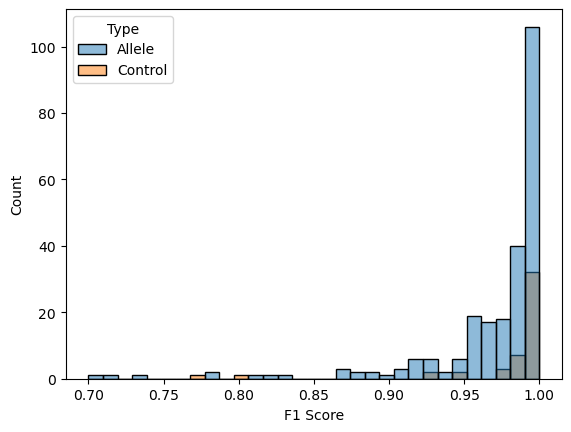

In [15]:
sb.histplot(data=plot_csv, x="F1 Score", hue="Type", binrange=(0.7, 1.0))
plt.show()